In [8]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from math import sqrt
import re

#oma moodulid
import Spectra as sp
from fittings import fit_single_shape, fit_single_shape_colnames

def fitToModel(data, model, prange, pwrref = None, pwrvar = None, absref = None):
    ptrn = '-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[+-]?\ *[0-9]+)?' #kümnendmurru pattern re jaoks
    model = (list(range(*prange)),model[prange[0]:prange[1]])
    result = pd.DataFrame()
    a = []
    wl= []
    for n in data:
        a+= [n.spc[prange[0]:prange[1]]]
        wl += [float(re.search(ptrn,n.comment).group(0))]
    result['wl'] = wl
    result['data'] = a
    fitted,params =  fit_single_shape(np.array(a), list(range(*prange)), model)
    result['fitted'] = list(fitted)
    #fittingu parameetrid
    for i,col in enumerate(fit_single_shape_colnames()):
        result[col] = params.T[i]
    #neeldumise koef, kui vaja
    if absref is None:
        result['coef'] = 1
    else:
        result['coef'] = pow(10,absref(result['wl']))
    #võimsusreferents
    if pwrref is None:
        #proovime ekstraheerida commendist
        result['power'] = [float(re.search('[uW]'+ptrn,n.comment).group(0)[1:]) for n in data]
        result['pwr-Err'] = [float(re.search('[var]'+ptrn,n.comment).group(0)[1:]) for n in data]
    else:
        if callable(pwrref): #antud on interpolatsioonifunktsioon
            result['power'] = pwrref(result['wl'])
            result['pwr-Err'] = pwrvar(result['wl'])*2.58
        else: #antud on list või array väärtustega
            result['power'] = pwrref
            result['pwr-Err'] = np.array(pwrvar)*2.58
    result['Excit'] = result['a']/(result['power']*result['coef'])
    result['relerr'] = result['a-Err']/result['a'] + result['pwr-Err']/result['power']
    return result

def adjust(target, fixed):
    f = interp1d(fixed["wl"],fixed["ExcitAdj"])
    fe = interp1d(fixed["wl"],fixed["relerr"])
    ratios = []
    rterrs = []
    
    for index, row in target.iterrows():
        k = row["wl"]
        try:
            ex =  f(k)
            err = fe(k) #see võib mõnes punktis veidi kahtlane olla
            ratios += [ex /  row["Excit"]]
            rterrs += [err + row["relerr"]]
        except ValueError: #siia jõuavad kõik peale kattuvate
            pass
    #leiame vastava kaalutud keskmise ja selle errori
    b = sum(np.array(ratios)/(np.array(rterrs)**2))
    c = sum(1/(np.array(rterrs)**2))
    mean = b / c
    err = sqrt(1 / c) #seda hetkel ei kasuta
    target['ExcitAdj'] = target['Excit'] * mean
    target['Excit-Err'] = target['ExcitAdj'] * target['relerr']


Antud juhul on siin põhiliselt rakus tehtud (peaaegu) ilma rõhuta spektrid, viimane mõõtmine oli ka rõhuga, aga seal oli rõhk vist liiga suur. Määrame ta hiljem ära ka. 

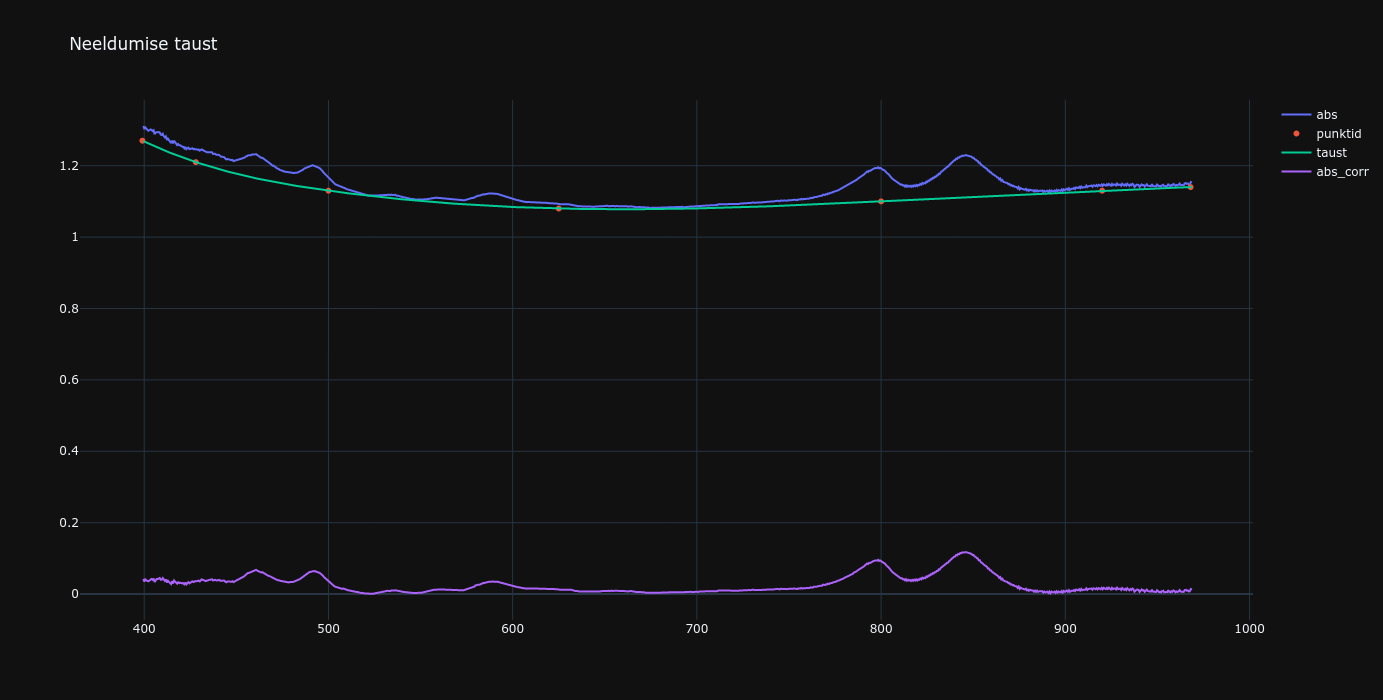

In [9]:
#proovime neeldumisele mingi taustjoone tekitada
import plotly.graph_objects as go
from scipy.interpolate import splrep, splev
abssig = sp.Spectra("lisa210413.spc")[0] # 0-alg 
absx = abssig.xVect()
#defineerime mõned punktid
#bpoints = np.array([[399,1.2],[428,1.1], [500, 1],  [625,0.98], [800,0.98], [920,1.035],[968,1.055]]) #0
bpoints = np.array([[399,1.27],[428,1.21], [500, 1.13],  [625,1.08], [800,1.1], [920,1.13],[968,1.14]]) #1
#ja nende vahele kuupspliin-joone (teatud juhul võiks lin. interpolatsioon olla paremgi)
back = splev(absx, splrep(bpoints.T[0], bpoints.T[1], s = 0), der = 0)
#mille lahutame esialgsest neeldumisest
abs_corr = abssig.spc - back

#Kirjutame absi faili
absout = pd.DataFrame()
absout['wl'] = absx
absout['abs'] =abs_corr
absout.to_csv("210413_abs.csv", sep = '	')

#teeme pildi
absfig = go.Figure(go.Scatter(x =absx,y=abssig.spc, mode = 'lines', name = "abs"))
absfig.add_trace(go.Scatter(x = bpoints.T[0], y = bpoints.T[1], mode = 'markers', name = "punktid"))
absfig.add_trace(go.Scatter(x = absx, y = back, mode = 'lines',name = "taust"))
absfig.add_trace(go.Scatter(x = absx, y = abs_corr, mode = 'lines',name = "abs_corr"))

absfig.update_layout(height = 700, title = "Neeldumise taust",template = "plotly_dark")
absfig

In [10]:
#TiSph 900- piirkond-----------------------------------------------
data = sp.Spectra("TiSph_900m.spc")
model = sp.Spectra("lisa210413.spc")[1]

#proovime power failist uued võimsused saada
#sest mitmel puhul algas kasutamiskõlbulik osa liiga hilja
s = sp.Spectra("TiSph_900m_power.spc")
mean = []
var = []
startpoint = 10
for c in s:
    mean += [np.mean(c.spc[startpoint:])]
    var += [np.var(c.spc[startpoint:])]

abscorr = interp1d(abssig.xVect(),abs_corr)#abssig.spc)
prange = (670,1020)
p900m = fitToModel(data,model.spc, prange, mean,var,abscorr)

#TiSph 900- piirkond ---------------------------------------------
data = sp.Spectra("TiSph_800p.spc")
model = sp.Spectra("lisa210413.spc")[2]

#proovime power failist jälle võimsused saada
s = sp.Spectra("TiSph_800p_power.spc")
mean = []
var = []
startpoint = 10
for c in s:
    mean += [np.mean(c.spc[startpoint:])]
    var += [np.var(c.spc[startpoint:])]

abscorr = interp1d(abssig.xVect(),abs_corr)#abssig.spc)
prange = (400,545)
p800p = fitToModel(data,model.spc, prange, mean,var,abscorr)#[15:]

#FES750 piirkond---------------------------------------------------
data = sp.Spectra("Chira_FES750.spc")
model = sp.Spectra("lisa210413.spc")[3]
pwr = pd.read_csv("../Chira_ref/pwr_FES750.csv", sep='\t')
pwrref = interp1d(pwr['wl'],pwr['pwr'])
pwrvar = interp1d(pwr['wl'],pwr['pwrvar'])
prange = (600,1020)
pFES750 = fitToModel(data,model.spc, prange, pwrref,pwrvar,None)

#C3C23 piirkond-1-(600+650LP)---------------------------------------
data = sp.Spectra("Chira_C3C23.spc")
model = sp.Spectra("lisa210413.spc")[4]
pwr = pd.read_csv("../Chira_ref/pwr_C3C23.csv", sep='\t')
pwrref = interp1d(pwr['wl'],pwr['pwr'])
pwrvar = interp1d(pwr['wl'],pwr['pwrvar'])
prange = (600,1020) #wl oli võrreldes FES750ga nihkes
pC3C23_1 = fitToModel(data,model.spc, prange, pwrref,pwrvar,None)



In [11]:
#interpolatiivne traageldamine
#Kõigepealt normeerime TiSph osa maksimumi
maxval = 0.117
p900m['ExcitAdj'] = p900m['Excit'] * maxval / max(p900m['Excit']) 
p900m['Excit-Err'] = p900m['ExcitAdj'] * p900m['relerr']
#siis haagime ülejäänud osad juurde
adjust(pFES750, p900m)
adjust(p800p, p900m)#mis juhtub?
#p800p['ExcitAdj'] *= 1.4 #täpsustame käsitsi üle
#p800p['Excit-Err'] *= 1.4 
adjust(pC3C23_1, pFES750)

#nüüd peaks mingi sumaarse ergastuse välja kirjutama
#võib-olla C3C23 jätame _2 
#ja praegu ka 900m ainult?
excit_sum = pd.DataFrame()
excit_sum['wl']= np.concatenate((pC3C23_1['wl'],pFES750['wl'],p900m['wl']))
excit_sum['Excit']= np.concatenate((pC3C23_1['ExcitAdj'],pFES750['ExcitAdj'],p900m['ExcitAdj']))
excit_sum['Excit-Err']= np.concatenate((pC3C23_1['Excit-Err'],pFES750['Excit-Err'],p900m['Excit-Err']))
excit_sum['set'] = len(pC3C23_1)*['C3C23'] + len(pFES750)*['FES750'] + len(p900m)*['900m']
excit_sum.sort_values(by=['wl'], inplace = True)
excit_sum.to_csv("210413_excit.csv", sep = '	')


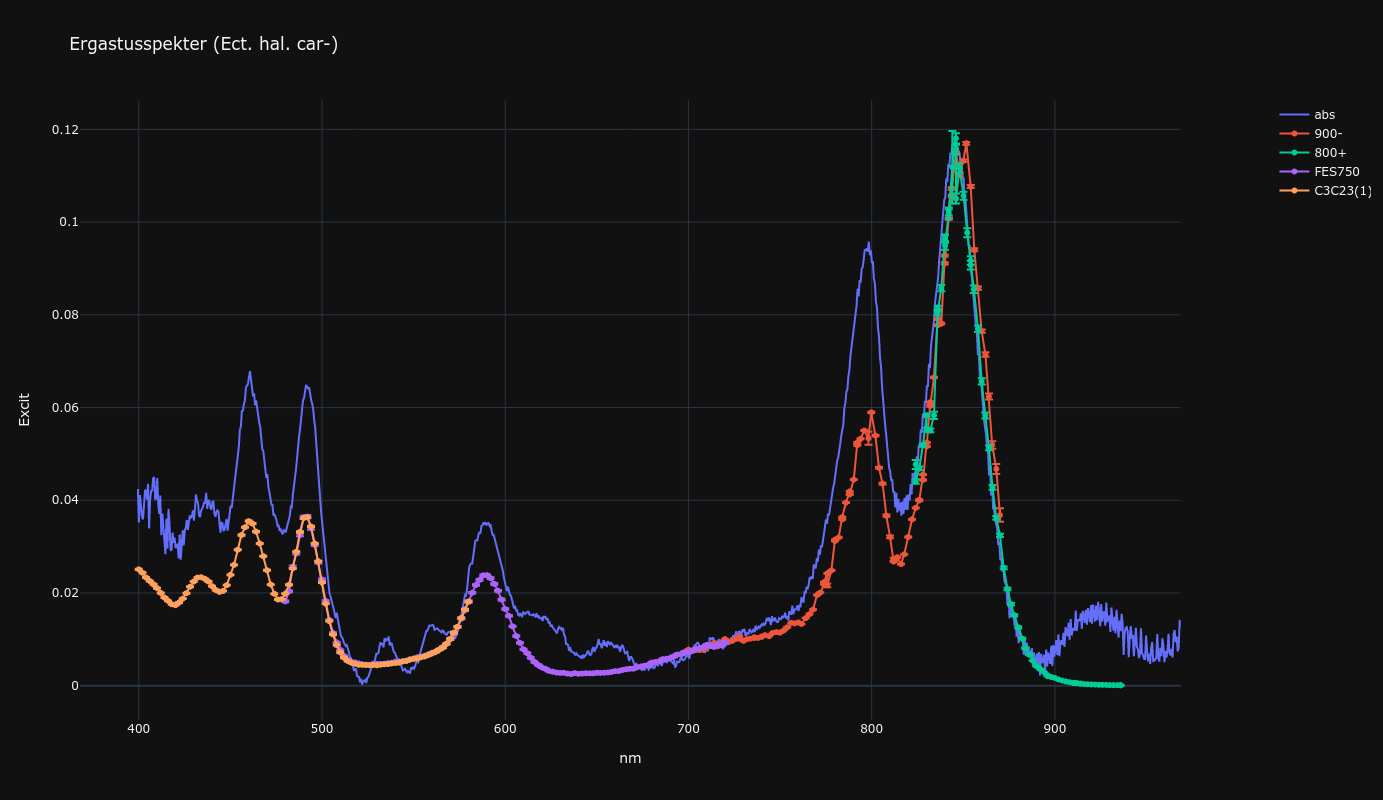

In [12]:

from plotly.subplots import make_subplots
fig1 = make_subplots(specs=[[{"secondary_y": True}]])

fig1.add_trace(go.Scatter(x =abssig.xVect(),y=abs_corr, mode = 'lines', name = "abs"),  secondary_y=False)
fig1.add_trace(go.Scatter(x =p900m['wl'], y=p900m['ExcitAdj'], error_y = dict(type = 'data', array = p900m['Excit-Err'], visible = True), mode = 'lines+markers', name = "900-"))
fig1.add_trace(go.Scatter(x =p800p['wl'], y=p800p['ExcitAdj'], error_y = dict(type = 'data', array = p800p['Excit-Err'], visible = True), mode = 'lines+markers', name = "800+"))
fig1.add_trace(go.Scatter(x =pFES750['wl'], y=pFES750['ExcitAdj'], error_y = dict(type = 'data', array = pFES750['Excit-Err'], visible = True), mode = 'lines+markers', name = "FES750"))
fig1.add_trace(go.Scatter(x =pC3C23_1['wl'], y=pC3C23_1['ExcitAdj'], error_y = dict(type = 'data', array = pC3C23_1['Excit-Err'], visible = True), mode = 'lines+markers', name = "C3C23(1)"))


#fig1.add_trace(go.Scatter(x =absref.xVect(),y=absref.spc, mode = 'lines', name = "abs_ref"))
fig1.update_layout(height = 800, title = "Ergastusspekter (R.Sp. )",template = "plotly_dark")
#fig1.layout.yaxis.range = [-10,8000]
fig1.layout.xaxis.title = "nm"
fig1.layout.yaxis.title = "Excit"
fig1

In [13]:
src = p800p

fig2 = go.FigureWidget(data=go.Scatter(x=list(range(*prange)), y=src['data'][0] , mode = 'lines', name = 'sig'))
fig2.add_trace(go.Scatter(x=list(range(*prange)), y=src['fitted'][0] , mode = 'lines', name = 'ref'))
#fig2.add_trace(go.Scatter(x =sig[0].xVect(), y=np.array(sig[0].spc) - np.array(ref[0].spc), mode = 'lines', name = 'diff'))
#fig2.layout.yaxis.range = [-10,4500]
fig2.update_layout(height = 600,template = "plotly_dark")
fig2

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'sig',
              'type': 'scatter',
  …

In [14]:
from ipywidgets import IntSlider


slider = IntSlider(
    orientation='horizontal',
    value=0,
    min=0,max=len(src['data']) - 1
)

def update(spno):

    #fig2.data[0].x = sig[slider.value].xVect() 
    fig2.data[0].y = src['data'][slider.value]
    #fig2.data[1].x = ref[slider.value].xVect() 
    fig2.data[1].y = src['fitted'][slider.value]
    #fig2.data[2].y = np.array(sig[slider.value].spc) - np.array(ref[slider.value].spc)
    fig2.layout.title = src['wl'][slider.value]

slider.observe(update, names='value')
slider

IntSlider(value=0, max=73)